In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import sys
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
import netCDF4 as nc
import re

In [4]:
# nncamrh_path = "/Users/jianda/Projects/experience_replay_data/nncamrh/nc_files/"
nncam_path = "/Users/jiandachen/Projects/Experience_replay_data/nncam_wang/"
er_1117_std_path = "/Users/jiandachen/Projects/Experience_replay_data/er1117/nc_files/"
er_1117_precip_path = "/Users/jiandachen/Projects/Experience_replay_data/er1117_precip/"
er_1117_precip_iw_path = "/Users/jiandachen/Projects/Experience_replay_data/er1117_precip_iw/"
er_1117_precip_iw10_path = "/Users/jiandachen/Projects/Experience_replay_data/er1117_precip_iw_sampled12/"


In [5]:
def load_precip_from_h1_nc(nc_dir_path, include_pattern=None, exclude_pattern=None):
    """
    Load precipitation data from h1.nc files in the given directory.
    Args:
        nc_dir_path (str): The directory path containing the h1.nc files.
        include_pattern (str): A regex pattern to include only specific files.
        exclude_pattern (str): A regex pattern to exclude specific files. include pattern is proritized over exclude pattern.
    Returns:
        pd.DataFrame: A concatenated DataFrame of precipitation data with time index.
    """
    dfs = []
    files = os.listdir(nc_dir_path)
    if exclude_pattern is not None:
        files = [file for file in files if not re.search(exclude_pattern, file)]
        excluded_files = [file for file in files if re.search(exclude_pattern, file)]
    if include_pattern is not None:
        included_files = [file for file in excluded_files if re.search(include_pattern, file)]
        files.extend(included_files)
    for file in files:
        if "h1" in file and file.endswith(".nc"):
            print(file)
            nc_file = nc.Dataset(nc_dir_path + file)
            nc_data = nc_file["cp"][:]
            nc_data = nc_data * 24 * 60 * 60 * 1000
            print(nc_data.mean())
            time = nc_file["time"]
            # Convert time to datetime
            time_values = nc.num2date(time[:], time.units)
            # Reshape precipitation arrays to 2D (time, lat*lon)
            nc_data_flat = nc_data.reshape(nc_data.shape[0], -1)
            # Convert cftime DatetimeGregorian to pandas datetime
            time_values_pd = pd.to_datetime([str(t) for t in time_values])
            # Create DataFrames with time index
            nc_df = pd.DataFrame(nc_data_flat, index=time_values_pd)
            dfs.append(nc_df)
            nc_file.close()
    concat_df = pd.concat(dfs)
    concat_df = concat_df.sort_index()
    return concat_df


In [6]:
spcam_precip = pd.read_csv("/Users/jiandachen/Projects/Experience_replay_data/spcam/spcam_precip.csv")
spcam_precip['Unnamed: 0'] = pd.to_datetime(spcam_precip['Unnamed: 0'])
spcam_precip.set_index('Unnamed: 0', inplace=True)
spcam_precip = spcam_precip.sort_index()

In [7]:
spcam_nc_data = nc.Dataset("/Users/jiandachen/Projects/Experience_replay_data/spcam/spcam.cam.h1.day.1999-2003.nc")
print(spcam_nc_data["precip"])
print((spcam_nc_data["precip"][:]*24*3600*1000).mean())
spcam_precip2 = spcam_nc_data["precip"][:]
time = spcam_nc_data["time"][:]
print(time)
# Convert time to datetime
time_values = nc.num2date(time[:], spcam_nc_data["time"].units)
print(time_values.shape)

# Reshape precipitation arrays to 2D (time, lat*lon)
spcam_precip_flat = spcam_precip2.reshape(spcam_precip2.shape[0], -1)*24*3600*1000
time_values_pd = pd.to_datetime([str(t) for t in time_values])

# Create DataFrames with time index
spcam_df = pd.DataFrame(spcam_precip_flat, index=time_values_pd)
spcam_full = pd.concat([spcam_precip, spcam_df])

<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    units: m/s
    long_name: CRM calculated convective precipitation
    average_op_ncl: dim_avg_n over dimension(s): time
    _FillValue: -9999.0
unlimited dimensions: time
current shape = (1825, 96, 144)
filling on
2.2801075
[ 365.  366.  367. ... 2187. 2188. 2189.]
(1825,)


In [8]:
cam5_nc_data = nc.Dataset("/Users/jiandachen/Projects/Experience_replay_data/cam/2021_10_21.cam.h1.day.1999-2003.nc")
print(cam5_nc_data["precip"])
print((cam5_nc_data["precip"][:]*24*3600*1000).mean())
cam5_precip = cam5_nc_data["precip"][:]
time = cam5_nc_data["time"][:]
print(time)
# Convert time to datetime
time_values = nc.num2date(time[:], cam5_nc_data["time"].units)
print(time_values.shape)

# Reshape precipitation arrays to 2D (time, lat*lon)
cam5_precip_flat = cam5_precip.reshape(cam5_precip.shape[0], -1)*24*3600*1000
time_values_pd = pd.to_datetime([str(t) for t in time_values])

# Create DataFrames with time index
cam5_df = pd.DataFrame(cam5_precip_flat, index=time_values_pd)

<class 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    _FillValue: 9.96921e+36
    units: m/s
    long_name: Precipitation
    cell_methods: time: mean
    time: 365.0
    NCL_tag: calculate_daily_values: arith=avg
unlimited dimensions: time
current shape = (1825, 96, 144)
filling on
2.3740873
[ 365.  366.  367. ... 2187. 2188. 2189.]
(1825,)


In [9]:
# nncamrh_precip = load_precip_from_h1_nc(nncamrh_path)
nncam_precip = load_precip_from_h1_nc(nncam_path)
er_1117_std_precip = load_precip_from_h1_nc(er_1117_std_path)
er_1117_precip_mix_precip = load_precip_from_h1_nc(er_1117_precip_path)

2021_11_15.cam.h1.1999-01-01-00000.nc
2.3345423
2021_11_15.cam.h1.1998-01-01-00000.nc
2.3331063
2021_11_15.cam.h1.2000-01-01-00000.nc
2.322086
2021_11_15.cam.h1.2001-01-01-00000.nc
2.3089302
2021_11_15.cam.h1.2003-01-01-00000.nc
2.2701836
2021_11_15.cam.h1.2002-01-01-00000.nc
2.2891512
conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.1322532
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.1178088
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.086526
conv_mem_share3.cam.h1.1998-12-27-00000.nc
2.1011922
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.1122305
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.2531095
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.164281
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.1182451
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.2183273
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.1425037
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.1716425
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.2504485
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1595287
conv_mem_share3.cam.h1.199

In [10]:
er_1117_precip_iw_precip = load_precip_from_h1_nc(er_1117_precip_iw_path)
er_1117_precip_iw10_precip = load_precip_from_h1_nc(er_1117_precip_iw10_path)

conv_mem_share3.cam.h1.2003-01-01-00000.nc
2.1318395
conv_mem_share3.cam.h1.2004-01-01-00000.nc
1.8923656
conv_mem_share3.cam.h1.2002-01-01-00000.nc
2.136798
conv_mem_share3.cam.h1.2000-01-01-00000.nc
2.1361787
conv_mem_share3.cam.h1.2001-01-01-00000.nc
2.1256442
conv_mem_share3.cam.h1.1999-01-01-00000.nc
2.1267715
conv_mem_share3.cam.h1.1998-01-01-00000.nc
2.1705117
conv_mem_share3.cam.h1.1998-11-27-00000.nc
2.0668619
conv_mem_share3.cam.h1.1998-01-31-00000.nc
2.1447608
conv_mem_share3.cam.h1.1998-10-28-00000.nc
2.0713532
conv_mem_share3.cam.h1.1998-12-27-00000.nc
1.9978483
conv_mem_share3.cam.h1.1998-09-28-00000.nc
2.0940135
conv_mem_share3.cam.h1.1998-07-30-00000.nc
2.2299442
conv_mem_share3.cam.h1.1998-05-01-00000.nc
2.1971307
conv_mem_share3.cam.h1.1998-03-02-00000.nc
2.0926497
conv_mem_share3.cam.h1.1998-05-31-00000.nc
2.215006
conv_mem_share3.cam.h1.1998-04-01-00000.nc
2.1229365
conv_mem_share3.cam.h1.1998-08-29-00000.nc
2.208287
conv_mem_share3.cam.h1.1998-06-30-00000.nc
2.2347

In [11]:
PLOT_CONFIG = {
    'xlabel': 'mm/day',
    'ylabel': 'Probability Density (%)',
    'title': 'Precipitation 1998 Bin size: 1mm/day',
    'ylim': (1e-7, 100),
    'xlim': (0, 220),
    'xticks': range(0, 221, 20),
    'yticks': {
        'values': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
        'labels': ['$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1', '10', '100']
    },
     'figsize': (10, 8),
    'legend_loc': 'upper right',
    'legend_fontsize': 12,
    'label_fontsize': 12,
    'title_fontsize': 14,
    'tick_fontsize': 10,
    'colors': ['black', 'orange', 'orange', 'red', 'red', 'purple', 'purple', 'pink', 'pink']
}

Setting plot limits and ticks


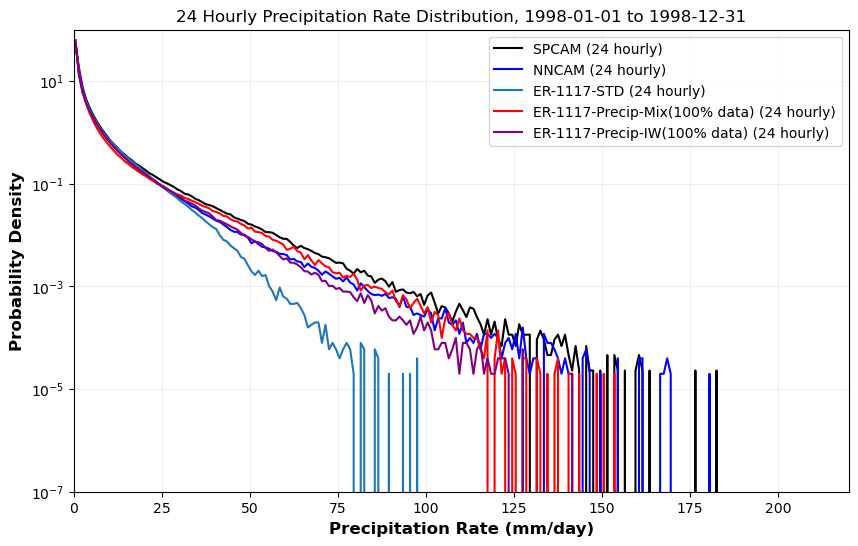

In [14]:
date_start = '1998-01-01'
date_end = '1998-12-31'
# Resample to 6 hourly averages using pandas
spcam_hourly = spcam_precip.loc[date_start:date_end].resample('24h').mean(0)
# nncamrh_hourly = nncamrh_precip.loc[date_start:date_end].resample('24h').mean(0)
nncam_hourly = nncam_precip.loc[date_start:date_end].resample('24h').mean(0)
er_1117_std_hourly = er_1117_std_precip.loc[date_start:date_end].resample('24h').mean(0)
er1117_precip_mix_hourly = er_1117_precip_mix_precip.loc[date_start:date_end].resample('24h').mean(0)
er_1117_precip_iw_hourly = er_1117_precip_iw_precip.loc[date_start:date_end].resample('24h').mean(0)

# nncam_switch_er_hourly = nncam_switch_er_precip.loc[date_start:date_end].resample('24h').mean(0)
# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_spcam, bins_spcam = np.histogram(spcam_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam, bins_nncam = np.histogram(nncam_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_std, bins_er_1117_std = np.histogram(er_1117_std_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_precip_mix, bins_er_1117_precip_mix = np.histogram(er1117_precip_mix_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_precip_iw, bins_er_1117_precip_iw = np.histogram(er_1117_precip_iw_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
bin_centers_er_1117_std = (bins_er_1117_std[:-1] + bins_er_1117_std[1:]) / 2
bin_centers_er_1117_precip_mix = (bins_er_1117_precip_mix[:-1] + bins_er_1117_precip_mix[1:]) / 2
bin_centers_er_1117_precip_iw = (bins_er_1117_precip_iw[:-1] + bins_er_1117_precip_iw[1:]) / 2


plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)',color='black')
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM (24 hourly)',color='blue')
plt.semilogy(bin_centers_er_1117_std, hist_er_1117_std*100, label='ER-1117-STD (24 hourly)')
plt.semilogy(bin_centers_er_1117_precip_mix, hist_er_1117_precip_mix*100, label='ER-1117-Precip-Mix(100% data) (24 hourly)', color='red')
plt.semilogy(bin_centers_er_1117_precip_iw, hist_er_1117_precip_iw*100, label='ER-1117-Precip-IW(100% data) (24 hourly)', color='purple')

plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title(f'24 Hourly Precipitation Rate Distribution, {date_start} to {date_end}')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()


Setting plot limits and ticks


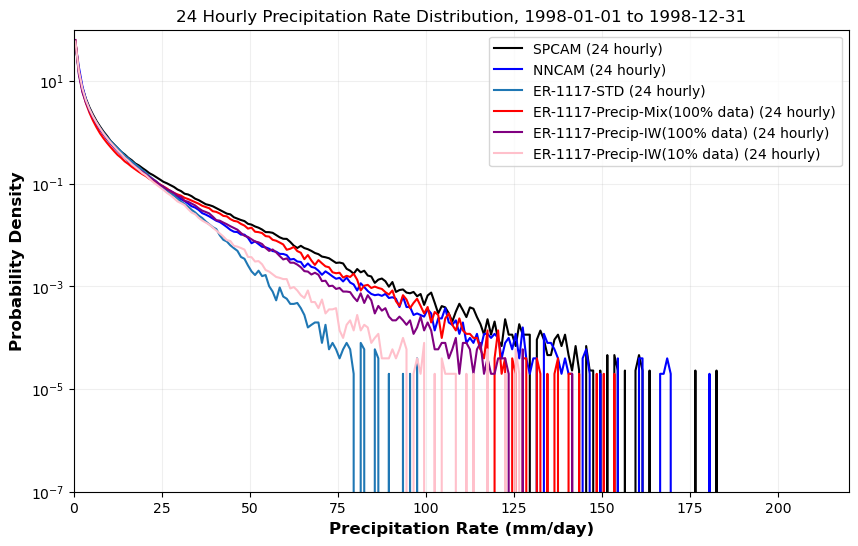

In [15]:
date_start = '1998-01-01'
date_end = '1998-12-31'
# Resample to 6 hourly averages using pandas
spcam_hourly = spcam_precip.loc[date_start:date_end].resample('24h').mean(0)
# nncamrh_hourly = nncamrh_precip.loc[date_start:date_end].resample('24h').mean(0)
nncam_hourly = nncam_precip.loc[date_start:date_end].resample('24h').mean(0)
er_1117_std_hourly = er_1117_std_precip.loc[date_start:date_end].resample('24h').mean(0)
er1117_precip_mix_hourly = er_1117_precip_mix_precip.loc[date_start:date_end].resample('24h').mean(0)
er_1117_precip_iw_hourly = er_1117_precip_iw_precip.loc[date_start:date_end].resample('24h').mean(0)
er_1117_precip_iw10_hourly = er_1117_precip_iw10_precip.loc[date_start:date_end].resample('24h').mean(0)

# nncam_switch_er_hourly = nncam_switch_er_precip.loc[date_start:date_end].resample('24h').mean(0)
# Create histogram for hourly data
plt.figure(figsize=(10, 6))
hist_spcam, bins_spcam = np.histogram(spcam_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_nncam, bins_nncam = np.histogram(nncam_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_std, bins_er_1117_std = np.histogram(er_1117_std_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_precip_mix, bins_er_1117_precip_mix = np.histogram(er1117_precip_mix_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_precip_iw, bins_er_1117_precip_iw = np.histogram(er_1117_precip_iw_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
hist_er_1117_precip_iw10, bins_er_1117_precip_iw10 = np.histogram(er_1117_precip_iw10_hourly, bins=np.linspace(0, PLOT_CONFIG['xlim'][1], PLOT_CONFIG['xlim'][1]+1), density=True)
plt.clf()  # Clear the histogram plots

bin_centers_spcam = (bins_spcam[:-1] + bins_spcam[1:]) / 2
bin_centers_nncam = (bins_nncam[:-1] + bins_nncam[1:]) / 2
bin_centers_er_1117_std = (bins_er_1117_std[:-1] + bins_er_1117_std[1:]) / 2
bin_centers_er_1117_precip_mix = (bins_er_1117_precip_mix[:-1] + bins_er_1117_precip_mix[1:]) / 2
bin_centers_er_1117_precip_iw = (bins_er_1117_precip_iw[:-1] + bins_er_1117_precip_iw[1:]) / 2
bin_centers_er_1117_precip_iw10 = (bins_er_1117_precip_iw10[:-1] + bins_er_1117_precip_iw10[1:]) / 2


plt.semilogy(bin_centers_spcam, hist_spcam*100, label='SPCAM (24 hourly)',color='black')
plt.semilogy(bin_centers_nncam, hist_nncam*100, label='NNCAM (24 hourly)',color='blue')
plt.semilogy(bin_centers_er_1117_std, hist_er_1117_std*100, label='ER-1117-STD (24 hourly)')
plt.semilogy(bin_centers_er_1117_precip_mix, hist_er_1117_precip_mix*100, label='ER-1117-Precip-Mix(100% data) (24 hourly)', color='red')
plt.semilogy(bin_centers_er_1117_precip_iw, hist_er_1117_precip_iw*100, label='ER-1117-Precip-IW(100% data) (24 hourly)', color='purple')
plt.semilogy(bin_centers_er_1117_precip_iw10, hist_er_1117_precip_iw10*100, label='ER-1117-Precip-IW(10% data) (24 hourly)', color='pink')

plt.xlabel(PLOT_CONFIG['xlabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.ylabel(PLOT_CONFIG['ylabel'], fontweight='bold', fontsize=PLOT_CONFIG['label_fontsize'])
plt.legend(loc=PLOT_CONFIG['legend_loc'], fontsize=PLOT_CONFIG['legend_fontsize'])
plt.grid(True, which="both", ls="-", alpha=0.2)

print("Setting plot limits and ticks")
plt.ylim(*PLOT_CONFIG['ylim'])
# print(PLOT_CONFIG['xlim'])
plt.xlim(*PLOT_CONFIG['xlim'])

plt.xticks(PLOT_CONFIG['xticks'], fontsize=PLOT_CONFIG['tick_fontsize'])
plt.yticks(PLOT_CONFIG['yticks']['values'],
            PLOT_CONFIG['yticks']['labels'],
            fontsize=PLOT_CONFIG['tick_fontsize'])

plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Probability Density')
plt.title(f'24 Hourly Precipitation Rate Distribution, {date_start} to {date_end}')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.xscale('linear')
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()
